In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
# src 디렉토리 경로 추가
src_path = Path("../src")  # notebooks에서 src로 이동하는 상대 경로
sys.path.append(str(src_path))

# Configuration

In [3]:
datasets = ["rico", "publaynet"]  # choices
tasks = ["gent", "gents", "genr", "completion", "refinement"]
dataset = datasets[0]
task = tasks[0]
input_format = "seq"
output_format = "html"
add_unk_token = False
add_index_token = True
add_sep_token = True
candidate_size = -1  # -1 represents the complete training set
num_prompt = 1

# 데이터셋 준비

In [ ]:
# import os

# from preprocess import create_processor
# from utils import RAW_DATA_PATH, read_pt, write_pt
# from tqdm import tqdm

# processor = create_processor(dataset=dataset, task=task)
# base_dir = os.path.dirname(os.getcwd())

# def get_processed_data(split):
#     filename = os.path.join(
#         base_dir, "dataset", dataset, "processed", task, f"{split}.pt"
#     )
#     if os.path.exists(filename):
#         processed_data = read_pt(filename)
#     else:
#         processed_data = []
#         os.makedirs(os.path.dirname(filename), exist_ok=True)
#         raw_path = os.path.join(RAW_DATA_PATH(dataset), f"{split}.pt")
#         raw_data = read_pt(raw_path)
#         for rd in tqdm(raw_data, desc=f"{split} data processing..."):
#             processed_data.append(processor(rd))
#         write_pt(filename, processed_data)
#     return processed_data


# processed_train_data = get_processed_data("train")
# processed_val_data = get_processed_data("val")
# processed_test_data = get_processed_data("test")

In [12]:
import os
# train_이미지 폴더에서 모든 이미지
train_image_path = r'C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\original_img\trainjpg\\'  # 이미지 폴더 경로 설정
train_image_files = [os.path.join(train_image_path, img) for img in os.listdir(train_image_path)]

test_image_path = r'C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\original_img\testjpg\\'  # 이미지 폴더 경로 설정
test_image_files = [os.path.join(test_image_path, img) for img in os.listdir(test_image_path)]

In [13]:
# 이름을 추가한 데이터셋들 불러오기
import pickle
import os
name_add_processed_test_set_dir = r"C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\processed\named_data\name_add_processed_test_set.pkl"
name_add_processed_train_set_dir = r"C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\processed\named_data\name_add_processed_train_set.pkl"
with open(name_add_processed_test_set_dir, 'rb') as f:
    processed_test_data = pickle.load(f)
with open(name_add_processed_train_set_dir, 'rb') as f:
    processed_train_data = pickle.load(f)

In [14]:
for test_data in processed_test_data:
    if test_data['name'].endswith('.json'):
        # .json을 .jpg로 변경
        test_data['name'] = test_data['name'].replace('.json', '.jpg')

for train_data in processed_train_data:
    if train_data['name'].endswith('.json'):
        # .json을 .jpg로 변경
        train_data['name'] = train_data['name'].replace('.json', '.jpg')

In [15]:
# 제거할 인덱스 리스트
indices_to_remove = [9, 12, 13, 17, 29, 30, 38, 50, 51, 53, 56, 57, 76, 79, 84, 85, 86, 87, 89, 90, 91, 94, 104, 112, 117, 118, 119, 122, 126, 127, 128, 132, 134, 137, 141, 145, 153, 156, 157, 161, 174, 177, 179, 180, 181, 182, 183, 184, 187, 188, 190, 194, 200, 201, 202, 210, 213, 219, 228, 231, 232, 237, 239, 240, 257, 260, 262, 263, 267, 268, 269, 270, 274, 285, 289, 290, 294, 298, 299, 300]
# 샘플 데이터 (예: processed_test_data)
# processed_test_data = [...]
# indices_to_remove에 있는 인덱스를 제거한 새로운 리스트 생성
processed_test_data = [item for i, item in enumerate(processed_test_data) if i not in indices_to_remove]
# 결과 확인
len(processed_test_data)

3649

### 사전 학습모델

In [10]:
# #  ViT
# import torch
# import timm  # timm 라이브러리에서 ViT 모델 사용
# from imgutils import extract_features

# vitModel = timm.create_model('vit_base_patch16_224', pretrained=True)
# vitModel.eval()  # 평가 모드로 설정
# image_files = [os.path.join(train_image_path, img) for img in os.listdir(train_image_path)]
# vit_feature_list = [extract_features(img, vitModel) for img in image_files]
# len(vit_feature_list)

In [16]:
# Load Vit Model
import torch
from torchvision import models
import timm  # timm 라이브러리에서 ViT 모델 사용
import pickle
import numpy as np

vitModel = timm.create_model('vit_base_patch16_224', pretrained=True)
vitModel.eval()  # 평가 모드로 설정
vit_dir = r"C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\pretrained_model\vit_feature_list.pkl"
with open(vit_dir, 'rb') as f:
    numpy_vit_feature_list = pickle.load(f)
numpy_vit_feature_list = np.array(numpy_vit_feature_list).astype('float32')

mobilenet_dir = r"C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\pretrained_model\mobileNet_feature_list.pkl"
with open(mobilenet_dir, 'rb') as f:
    mobilenet_feature_list = pickle.load(f)
numpy_mobilenet_feature_list = []
for feature_item in mobilenet_feature_list:
    numpy_mobilenet_feature_list.append(feature_item)
numpy_mobilenet_feature_list = np.array(numpy_mobilenet_feature_list).astype('float32')

mobilenetModel = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobilenetModel.eval()


# 1. ResNet50 모델 로드 (사전 학습된 ImageNet 가중치 사용, 최종 평균 풀링 레이어 포함)
resnetmodel = models.resnet50(pretrained=True)
resnetmodel.eval()  # 추론 모드 설정 (평가 모드)
resnet_dir = r"C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\pretrained_model\resnet_feature_list.pkl"
with open(resnet_dir, 'rb') as f:
    numpy_resnet_feature_list = pickle.load(f)
numpy_resnet_feature_list = np.array(numpy_resnet_feature_list).astype('float32')

# 3. EfficientNetB0 모델 로드 (사전 학습된 ImageNet 가중치 사용, 최종 풀링 레이어 포함)
efficientnet_b0model = models.efficientnet_b0(pretrained=True)
efficientnet_b0model.eval()  # 추론 모드로 설정 (평가 모드)

efficientnet_dir = r"C:\Users\didtn\LayoutGeneration\LayoutPrompter\LayoutGeneration-main\LayoutGeneration-main\LayoutPrompter\dataset\rico\pretrained_model\efficientnet_feature_list.pkl"
with open(efficientnet_dir, 'rb') as f:
    numpy_efficientnet_feature_list = pickle.load(f)
numpy_efficientnet_feature_list = np.array(numpy_efficientnet_feature_list).astype('float32')

Using cache found in C:\Users\didtn/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\didtn\.conda\envs\layoutprompter\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\didtn\.conda\envs\layoutprompter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\didtn\.conda\envs\layoutprompter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equ

In [17]:
import faiss

dimension = numpy_vit_feature_list.shape[1]  # 벡터 차원 (ResNet50의 경우 2048)
vit_faiss_index = faiss.IndexFlatL2(dimension)  # L2 거리 기반의 FAISS 인덱스 생성
vit_faiss_index.add(numpy_vit_feature_list)

dimension = numpy_resnet_feature_list.shape[1]
resnet_faiss_index = faiss.IndexFlatL2(dimension) 
resnet_faiss_index.add(numpy_resnet_feature_list)

dimension = numpy_mobilenet_feature_list.shape[1]
mobilenet_faiss_index = faiss.IndexFlatL2(dimension) 
mobilenet_faiss_index.add(numpy_mobilenet_feature_list)

dimension = numpy_efficientnet_feature_list.shape[1]
efficient_faiss_index = faiss.IndexFlatL2(dimension) 
efficient_faiss_index.add(numpy_efficientnet_feature_list)

In [18]:
imgPretrainedModel = {'vit':vitModel, 'resnet': resnetmodel, 'mobilenet': mobilenetModel, "efficient": efficientnet_b0model}
imgFeatureList = {'vit':numpy_vit_feature_list, 'resnet': numpy_resnet_feature_list, 'mobilenet': numpy_mobilenet_feature_list, "efficient": numpy_efficientnet_feature_list}
imgFaissIndex={"vit":vit_faiss_index,  'resnet': resnet_faiss_index, 'mobilenet': mobilenet_faiss_index, "efficient": efficient_faiss_index}

# 이미지 메소드

In [19]:
from io import BytesIO
import base64
from imgutils import find_faiss_similar_images, find_similar_images

def getSimilarImagesByModel(query_image, num_img_prompt, isFaiss):
    modelName = 'vit'
    if isFaiss:
        similar_images = find_faiss_similar_images(query_image, imgPretrainedModel[modelName], imgFaissIndex[modelName], train_image_files, top_k=num_img_prompt)
    else:
        similar_images = find_similar_images(query_image, imgPretrainedModel[modelName], imgFeatureList[modelName], train_image_files, top_k=num_img_prompt)

    similar_image_names = [os.path.basename(img) for img in similar_images]
    matching_data = []
    for name in similar_image_names:
        for item in processed_train_data:
            if item['name'] == name:
                matching_data.append(item)
                break
    return matching_data

# LLM 파라미터 정의

In [ ]:
modeltype = "gpt-4o-mini"
# modeltype = "gpt-3.5-turbo-instruct"
temperature = 0.7
max_tokens = 800
top_p = 1
frequency_penalty = 0
presence_penalty = 0
num_return = 1
stop_token = "\n\n"
os.environ["OPENAI_API_KEY"] = ""

In [21]:
from openai import OpenAI

client = OpenAI()

# 클래스 생성

In [22]:
from serialization import create_serializer
from selection import create_selector
from gpt_parsing import Gpt_parser

num_prompt = 3

serializer = create_serializer(
    dataset=dataset,
    task=task,
    input_format=input_format,
    output_format=output_format,
    add_index_token=add_index_token,
    add_sep_token=add_sep_token,
    add_unk_token=add_unk_token
)

selector = create_selector(
    task=task,
    train_data=processed_train_data,
    candidate_size=candidate_size,
    num_prompt=num_prompt,
)

parser = Gpt_parser(dataset=dataset, output_format=output_format)

In [23]:
from PIL import Image
from io import BytesIO
import base64
from imgutils import getBase64FromTestImage, getRealAugmentedImageFewshot
from serialization import create_serializer, build_prompt_image
from openai import OpenAI
import pandas as pd

img_results_df = pd.DataFrame(columns=['test_idx', 'response'])

for test_idx in range(101):
    test_data = processed_test_data[test_idx]
    query_image = test_image_path + test_data['name']
    test_img_base64 = getBase64FromTestImage(Image.open(query_image))

    #Few-shot 만들기
    matching_data = getSimilarImagesByModel(query_image, num_prompt, isFaiss=False)
    augmented_img_num = num_prompt - len(matching_data)
    example_df = getRealAugmentedImageFewshot(serializer, matching_data, augmented_img_num)

    system_prompt = build_prompt_image(serializer, dataset)
    messages = [{"role": "system", "content": system_prompt}]
    for i in range(len(example_df)):
        messages.append(
                {"role": "user", "content": [
                {"type": "text", "text": f"{example_df['Element'][i]}"},
                {"type": "image_url", "image_url": {
                    "url": f"data:image/png;base64,{example_df['Base64'][i]}"}
                }
                ]}
            )
        messages.append({"role": "assistant", "content": f"{example_df['HTML'][i]}"})
    messages.append(
        {"role": "user", "content": [
            {"type": "text", "text": f"{serializer.build_input(test_data)}"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{test_img_base64}"}
            }
        ]}
    )
    # Get response from OpenAI API
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        n = num_return,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty
    )

    # Parse and store the response
    try:
        if response is not None:
            parsed_response = parser(response)
            result_df = pd.DataFrame({
                'test_idx': [test_idx],
                'response': [parsed_response]
            })

            img_results_df = pd.concat([img_results_df, result_df], ignore_index=True)
    except AttributeError:
        print("div_tag is None, skipping find_all()")
    

In [20]:
print(response.choices[0].message.content)

<html>
<body>
<div class="canvas" style="left: 0px; top: 0px; width: 90px; height: 160px"></div>
<div class="text" style="index: 0; left: 19px; top: 8px; width: 52px; height: 12px"></div>
<div class="text" style="index: 1; left: 10px; top: 20px; width: 69px; height: 10px"></div>
<div class="text" style="index: 2; left: 10px; top: 34px; width: 69px; height: 10px"></div>
<div class="text" style="index: 3; left: 10px; top: 48px; width: 69px; height: 10px"></div>
<div class="text" style="index: 4; left: 10px; top: 62px; width: 69px; height: 10px"></div>
<div class="text" style="index: 5; left: 10px; top: 76px; width: 69px; height: 10px"></div>
<div class="text" style="index: 6; left: 10px; top: 90px; width: 69px; height: 10px"></div>
<div class="text" style="index: 7; left: 10px; top: 104px; width: 69px; height: 10px"></div>
<div class="text" style="index: 8; left: 10px; top: 118px; width: 69px; height: 10px"></div>
<div class="text button" style="index: 9; left: 2px; top: 136px; width: 40

# Visualization

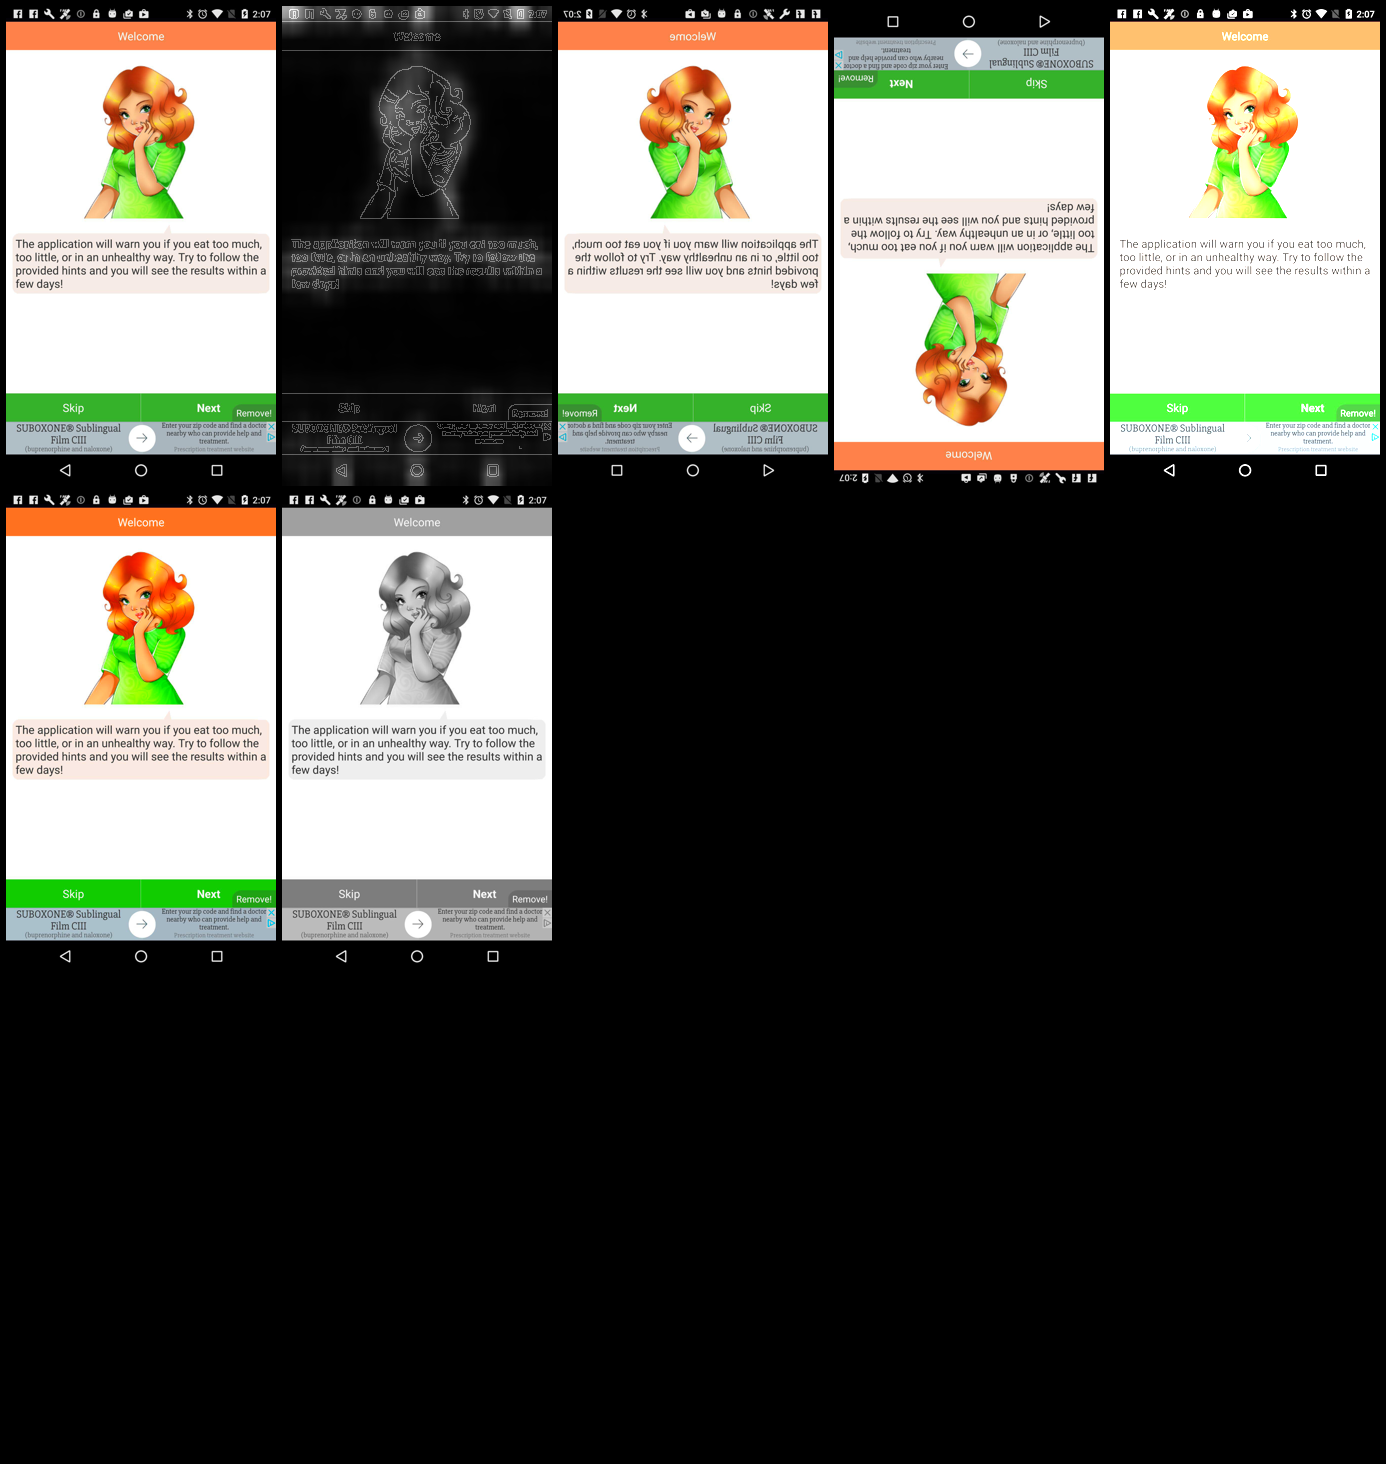

In [68]:
from visualization import Visualizer, create_image_grid
from PIL import Image
from imgutils import apply_flipping, apply_brightness, apply_grayscale, apply_rotation, apply_saturation, apply_saliency

# label_key='labels'
# bbox_key='discrete_gold_bboxes'
# html_output = serializer._build_html_output(test_data, label_key, bbox_key)
# print(html_output)


num_img_prompt = 3
test_data = processed_test_data[202]
query_image = test_image_path + test_data['name']

visualizer = Visualizer(dataset)
labels = test_data['labels']
bboxes = test_data['bboxes']
generated_images = visualizer([(labels, bboxes)])
testimg = generated_images[0]

images = []
image = Image.open(query_image)
resized_image = image.resize((testimg.width, testimg.height))

#인풋이미지
# images.append(testimg)
# images.append(resized_image)

# print(html_output)
matching_data = getSimilarImagesByModel(query_image, num_img_prompt, isFaiss=True)

#찾은 유사이미지
sample_image_path = train_image_path + matching_data[0]['name']
sample_image = Image.open(sample_image_path)
sample_image = sample_image.resize((testimg.width, testimg.height))
images.append(sample_image)

transformations = [
    apply_saliency,
    apply_flipping,
    apply_rotation,
    apply_brightness,
    apply_saturation,
    apply_grayscale,
]
for transform in transformations:
    transformed_img = transform(sample_image)
    images.append(transformed_img)

# 이미지들을 그리드 형태로 생성
create_image_grid(images)

# 평가

In [24]:
# calculate_ssim
from ranker import Ranker
from imgMetrics import calculate_ssim
from visualization import Visualizer

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)

visualizer = Visualizer(dataset)
length  = len(img_results_df)
ssimScores = []

for test_idx in range(length):
    response_values = img_results_df.loc[img_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        continue

    response_for_test_idx = response_values[0]
    if (response_for_test_idx == [[]] or (len(response_for_test_idx) == 0) or (len(response_for_test_idx[0][0]) == 0)):
        continue
    test_data = processed_test_data[test_idx]
    labels = test_data['labels']
    bboxes = test_data['bboxes']
    generated_images = visualizer([(labels, bboxes)])
    testimg = generated_images[0]

    ranked_response = ranker(response_for_test_idx)
    response = ranked_response[0]
    labels = response[0]  # response[0]은 라벨 텐서
    bboxes = response[1]  # response[1]은 바운딩 박스 텐서
    generated_images = visualizer([(labels, bboxes)])
    inferenceImg = generated_images[0]
    score = calculate_ssim(testimg, inferenceImg)
    ssimScores.append(score)

In [25]:
import numpy as np
np.mean(ssimScores)

0.7395350390914189

In [26]:
# calculate fid
from ranker import Ranker
from imgMetrics import calculate_fid

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)

visualizer = Visualizer(dataset)
length  = len(img_results_df)
fidScores = []

for test_idx in range(length):
    response_values = img_results_df.loc[img_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        continue

    response_for_test_idx = response_values[0]
    if (response_for_test_idx == [[]] or (len(response_for_test_idx) == 0) or (len(response_for_test_idx[0][0]) == 0)):
        continue
    test_data = processed_test_data[test_idx]
    labels = test_data['labels']
    bboxes = test_data['bboxes']
    generated_images = visualizer([(labels, bboxes)])
    testimg = generated_images[0]

    ranked_response = ranker(response_for_test_idx)
    response = ranked_response[0]
    labels = response[0]  # response[0]은 라벨 텐서
    bboxes = response[1]  # response[1]은 바운딩 박스 텐서
    generated_images = visualizer([(labels, bboxes)])
    inferenceImg = generated_images[0]
    score = calculate_fid(testimg, inferenceImg)
    fidScores.append(score)

c:\Users\didtn\.conda\envs\layoutprompter\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\didtn\.conda\envs\layoutprompter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
import numpy as np
np.mean(fidScores)

98.30379178144182

In [34]:
from ranker import Ranker
from utils import (
    compute_alignment,
    compute_maximum_iou,
    compute_overlap,
)

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)

outNum = 0
mIOUscore = 0
length  = len(img_results_df)
for test_idx in range(length):
    response_values = img_results_df.loc[img_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        outNum = outNum + 1
        continue

    response_for_test_idx = response_values[0]
    if (response_for_test_idx == [[]] or (len(response_for_test_idx) == 0) or (len(response_for_test_idx[0][0]) == 0)):
        outNum = outNum + 1
        continue
    ranked_response = ranker(response_for_test_idx)
    test_data = processed_test_data[test_idx]
    mIOUscore = mIOUscore + mIOU(test_data, ranked_response)

mIOUscore = mIOUscore / (length-outNum)

print(mIOUscore)

0.7708163323378799


In [33]:
from imgMetrics import calculateOverlap
from imgMetrics import calculateAllignment

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)
totalOverlap = 0
totalAllign = 0
cnt = 0
length  = len(img_results_df)
for test_idx in range(length):
    response_values = img_results_df.loc[img_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    response_for_test_idx = response_values[0]
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        continue
    if (response_for_test_idx == [[]] or len(response_for_test_idx[0][0]) == 0):
        print(f"No data for response_for_{test_idx}, skipping.")
        continue
    ranked_response = ranker(response_for_test_idx)
    totalOverlap = totalOverlap + calculateOverlap(ranked_response[0])
    totalAllign = totalAllign + calculateAllignment(ranked_response[0])
    cnt = cnt + 1
print("Overlap Score = " + str(totalOverlap/cnt))
print("Allign Score = " + str(totalAllign/cnt))

Overlap Score = 0.6108739862845528
Allign Score = 0.0007621626887760963


In [29]:
from utils import compute_maximum_iou, convert_ltwh_to_ltrb
## mIOU 결과값 출력
# 원본 데이터셋의 라벨 및 바운딩 박스
def mIOU(test_data, ranked_response):
    labels_1 = test_data['labels']
    bboxes_1 = test_data['bboxes']
    
    # 예측된 데이터셋의 라벨 및 바운딩 박스 리스트
    mIoUScroe = 0
    for response in ranked_response:
        labels_2 = response[0]  # response[0]은 라벨 텐서
        bboxes_2 = response[1]  # response[1]은 바운딩 박스 텐서
        # compute_maximum_iou 함수를 호출하여 최대 유사도 계산
        # _pred_labels = pred_labels.unsqueeze(0)
        # _pred_bboxes = convert_ltwh_to_ltrb(pred_bboxes).unsqueeze(0)
        iou_score = compute_maximum_iou(labels_1, bboxes_1, [labels_2], [bboxes_2])
        # 결과 출력
        if (iou_score > mIoUScroe):
            mIoUScroe = iou_score
            # print(f"Computed Maximum IOU Score: {iou_score}")
    # print(f"Max Score: {mIoUScroe}")
    return mIoUScroe

In [31]:
from utils import compute_overlap
import torch

def mOverlap(ranked_response):
    # 예측된 데이터셋의 라벨 및 바운딩 박스 리스트
    for response in ranked_response:
        labels_2 = response[0]  # response[0]은 라벨 텐서
        bboxes_2 = response[1]  # response[1]은 바운딩 박스 텐서

        _pred_labels = labels_2.unsqueeze(0)
        _pred_bboxes = convert_ltwh_to_ltrb(bboxes_2).unsqueeze(0)
        _pred_padding_mask = torch.ones_like(_pred_labels).bool()
        return compute_overlap(_pred_bboxes, _pred_padding_mask)

In [32]:
from utils import compute_alignment, convert_ltwh_to_ltrb
import torch
def mAllignment(ranked_response):
    # 예측된 데이터셋의 라벨 및 바운딩 박스 리스트
    for response in ranked_response:
        labels_2 = response[0]  # response[0]은 라벨 텐서
        
        bboxes_2 = response[1]  # response[1]은 바운딩 박스 텐서

        _pred_labels = labels_2.unsqueeze(0)
        _pred_bboxes = convert_ltwh_to_ltrb(bboxes_2).unsqueeze(0)
        _pred_padding_mask = torch.ones_like(_pred_labels).bool()
        return compute_alignment(_pred_bboxes, _pred_padding_mask)

# 그래픽으로 나타내기

In [ ]:
from visualization import Visualizer, create_image_grid

visualizer = Visualizer(dataset)
images = visualizer(ranked_response)
create_image_grid(images)